In [41]:
import pickle
import os
import networkx as nx
import walker as w
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import norm

In [2]:
with open('../../data/graphs/3000_similar_noUnknown_noFutureThr2_noIsolates.pkl', 'rb') as f:
    G = pickle.load(f)

In [3]:
# with open('../../data/batch/B_random_10.pkl', 'rb') as f:
#     B_random = pickle.load(f)
with open('../../data/batch/B_recent_10.pkl', 'rb') as f:
    B_recent = pickle.load(f)

In [6]:
graph_nodes = list(G.nodes())

In [7]:
def ids_to_indices(file_ids, nodes):
    index_map = {node: i for i, node in enumerate(nodes)}
    index_map_keys = set(index_map.keys())
    
    indices = []
    for file, ids in file_ids.items():
        for id in ids:
            if id in index_map_keys:
                indices.append(index_map[id])
    return indices

In [8]:
B_recent_idx = ids_to_indices(B_recent, graph_nodes)

In [9]:
walks = w.random_walks(G, n_walks=50, walk_len=5, start_nodes=B_recent_idx)

Random walks - T=85.83s


In [10]:
walks

array([[ 146871,   32225,  562150,  562153,  293895],
       [ 117538,    4098,   94781,   94781,   94781],
       [ 453162,  305575,  471767,   82862,   82852],
       ...,
       [1443531,  892254, 1538911,  572255,  572257],
       [ 839598, 2056471, 1426757, 1901239,  368124],
       [ 609916, 1171048,    5763,  320027,    5767]], dtype=uint32)

In [11]:
unique_walks = walks[~np.all(walks == walks[:,[0]], axis=1)]
print(len(walks) - len(unique_walks))
walks = unique_walks

In [20]:
# group walks by first node
walks_by_start = defaultdict(list)

for row in walks:
    walks_by_start[row[0]].append(row)
    
for key in walks_by_start:
    walks_by_start[key] = np.array(walks_by_start[key]).flatten()

In [21]:
# get unique ids for each walk
for key, walk_nodes in walks_by_start.items():
    ids = set(walk_nodes)
    # remove start node
    ids.remove(key)

    walks_by_start[key] = ids

In [ ]:
# filter out nodes with less than 10 neighbors
walks_by_start = {key: nodes for key, nodes in walks_by_start.items() if len(nodes) >= 10}

In [46]:
def plot_counts(node_walks, bins=100):
    counts = []
    for key, walk_nodes in node_walks.items():
        counts.append(len(walk_nodes))

    # print(len(counts), np.average(counts), np.median(counts), np.min(counts), np.max(counts))
    print(f"Number of target nodes: {len(counts)}")
    print(f"Average number of nodes in khop: {np.average(counts)}")
    print(f"Median number of nodes in khop: {np.median(counts)}")
    print(f"Min number of nodes in khop: {np.min(counts)}")
    print(f"Max number of nodes in khop: {np.max(counts)}")

    plt.hist(counts, bins=bins)
    plt.show()

def count_khop(khops, bins=100):
    target_counts = []
    khop_counts = []
    for targets, khop in khops:
        target_counts.append(len(targets))
        khop_counts.append(len(khop))

    print(f"Average number of targets: {np.average(target_counts)}")
    print(f"Average khop size: {np.average(khop_counts)}")
    print(f"Median khop size: {np.median(khop_counts)}")
    print(f"Min khop size: {np.min(khop_counts)}")
    print(f"Max khop size: {np.max(khop_counts)}")

    plt.hist(khop_counts, bins=bins)
    plt.show()

Number of target nodes: 222298
Average number of nodes in khop: 110.91046703074252
Median number of nodes in khop: 114.0
Min number of nodes in khop: 10
Max number of nodes in khop: 187


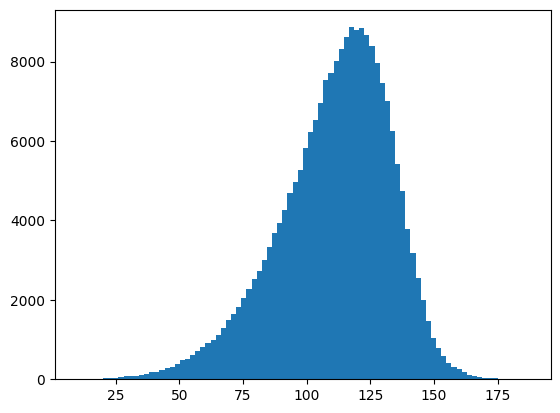

In [47]:
plot_counts(walks_by_start, bins=88)

In [50]:
target_nodes = walks_by_start.keys()

In [60]:
khops = []
for target_node in target_nodes:
    khop = set(walks_by_start[target_node])
    targets = {target_node}
    khops.append((targets, khop))

In [91]:
def merge_khops(current_khops: list):
    unmerged = current_khops.copy() # array of (set(targets), set(khop))
    merged_khops = []
    errs = 0
    for _ in (pbar := tqdm(range(len(unmerged) // 2))):
        # randomly pick two graphs to merge
        idx1, idx2 = np.random.choice(len(unmerged), 2, replace=False)
        graph1, graph2 = unmerged[idx1], unmerged[idx2]

        targets1, khop1 = graph1
        targets2, khop2 = graph2

        # check if targets and khops overlap
        overlap = False
        for i, k in ([targets1, khop2], [targets2, khop1]):
            # check if any target is in the other's khop
            if len(i.intersection(k)) > 0:
                # dont merge
                overlap = True
                break

        if overlap:
            errs += 1
            pbar.set_description(f'Merge conflicts: {errs}')
            continue

        # merge
        targets = targets1.union(targets2)
        khop = khop1.union(khop2)

        merged_khops.append((targets, khop))

        # remove merged graphs from unmerged
        unmerged = [graph for i, graph in enumerate(unmerged) if i not in [idx1, idx2]]

    return merged_khops, unmerged

def try_fully_merge(khops, tries=3):
    merged = []
    unmerged = khops.copy()

    for i in range(tries):
        tqdm.write(f'Try: {i+1}, {len(unmerged)} unmerged')

        m, unmerged = merge_khops(unmerged)
        merged = merged + m

        if len(unmerged) == 0:
            return merged

    print('Could not fully merge', len(unmerged))
    return merged + unmerged

In [80]:
merged_khops = try_fully_merge(khops)

Try: 1, 222298 unmerged


Merge conflicts: 3: 100%|██████████| 111149/111149 [28:10<00:00, 65.74it/s]  


Try: 2, 6 unmerged


100%|██████████| 3/3 [00:00<?, ?it/s]


Average number of targets: 2.0
Average khop size: 221.80411879549075
Median khop size: 224.0
Min khop size: 66
Max khop size: 336


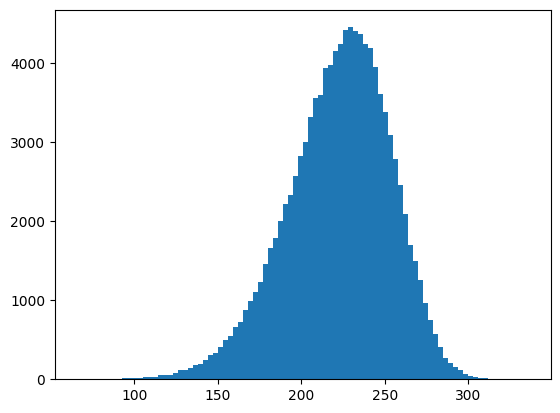

In [87]:
count_khop(merged_khops, bins=90)

In [90]:
merged_khops_2x = try_fully_merge(merged_khops)

Try: 1, 111149 unmerged


Merge conflicts: 11: 100%|██████████| 55574/55574 [10:38<00:00, 87.00it/s]  


Try: 2, 23 unmerged


100%|██████████| 11/11 [00:00<00:00, 11330.39it/s]


Try: 3, 1 unmerged


0it [00:00, ?it/s]


Try: 4, 1 unmerged


0it [00:00, ?it/s]


Try: 5, 1 unmerged


0it [00:00, ?it/s]


Try: 6, 1 unmerged


0it [00:00, ?it/s]


Try: 7, 1 unmerged


0it [00:00, ?it/s]


Try: 8, 1 unmerged


0it [00:00, ?it/s]


Try: 9, 1 unmerged


0it [00:00, ?it/s]


Try: 10, 1 unmerged


0it [00:00, ?it/s]

Could not fully merge 1


Average number of targets: 3.9999640125955915
Average khop size: 443.5366801619433
Median khop size: 446.0
Min khop size: 215
Max khop size: 601


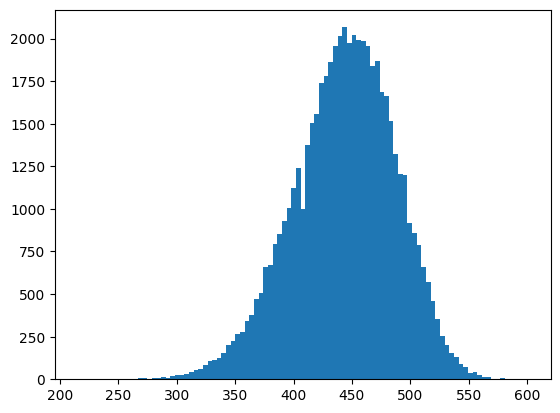

In [96]:
count_khop(merged_khops_2x, bins=97)

In [97]:
merged_khops_3x = try_fully_merge(merged_khops_2x)

Try: 1, 55575 unmerged


Merge conflicts: 20: 100%|██████████| 27787/27787 [02:51<00:00, 162.03it/s] 


Try: 2, 41 unmerged


100%|██████████| 20/20 [00:00<?, ?it/s]


Try: 3, 1 unmerged


0it [00:00, ?it/s]

Could not fully merge 1


Average number of targets: 7.99978407945876
Average khop size: 886.7752986900821
Median khop size: 890.0
Min khop size: 437
Max khop size: 1140


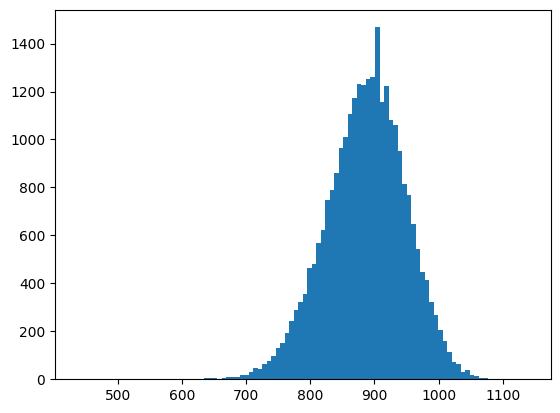

In [98]:
count_khop(merged_khops_3x, bins=100)

Try: 1, 27788 unmerged


Merge conflicts: 56: 100%|██████████| 13894/13894 [01:20<00:00, 172.00it/s] 


Try: 2, 112 unmerged


100%|██████████| 56/56 [00:00<00:00, 1792.08it/s]


Average number of targets: 15.99956815891752
Average khop size: 1772.4447243414425
Median khop size: 1775.0
Min khop size: 1320
Max khop size: 2074


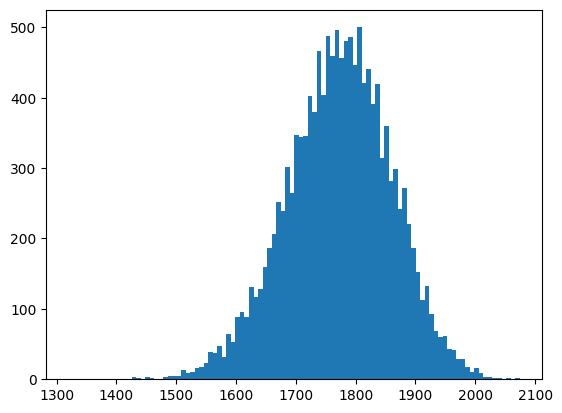

In [99]:
merged_khops_4x = try_fully_merge(merged_khops_3x)
count_khop(merged_khops_4x, bins=100)

Try: 1, 13894 unmerged


Merge conflicts: 94: 100%|██████████| 6947/6947 [00:33<00:00, 208.40it/s]


Try: 2, 188 unmerged


100%|██████████| 94/94 [00:00<00:00, 1492.22it/s]


Average number of targets: 31.99913631783504
Average khop size: 3540.458183388513
Median khop size: 3544.0
Min khop size: 2913
Max khop size: 3976


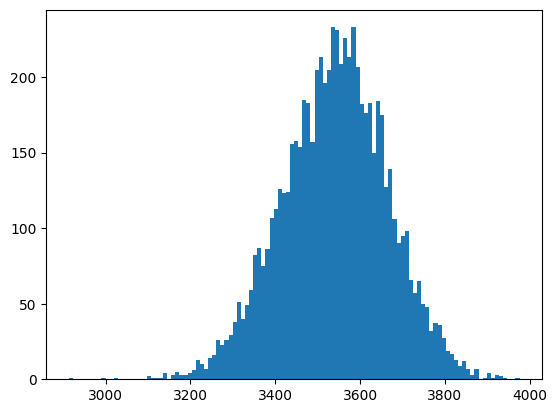

In [100]:
merged_khops_5x = try_fully_merge(merged_khops_4x)
count_khop(merged_khops_5x, bins=110)

Try: 1, 6947 unmerged


Merge conflicts: 170: 100%|██████████| 3473/3473 [00:11<00:00, 299.89it/s]


Try: 2, 341 unmerged


Merge conflicts: 7: 100%|██████████| 170/170 [00:00<00:00, 636.99it/s]


Try: 3, 15 unmerged


100%|██████████| 7/7 [00:00<?, ?it/s]


Could not fully merge 1
Average number of targets: 63.989061600460566
Average khop size: 7062.199769717904
Median khop size: 7063.0
Min khop size: 3514
Max khop size: 7630


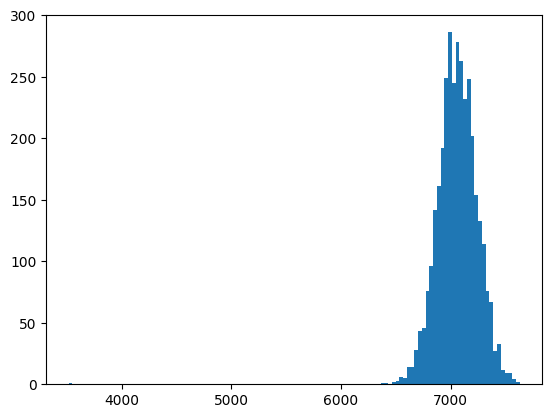

In [101]:
merged_khops_6x = try_fully_merge(merged_khops_5x)
count_khop(merged_khops_6x, bins=120)

In [104]:
def idx_to_id(idx):
    # idx is a single index or an array of indices
    return [graph_nodes[i] for i in idx]
def save_event_ids(merged_khops, filename, path='../../data/batch/'):
    to_save = []
    for targets, khop in merged_khops:
        to_save.append((idx_to_id(targets), idx_to_id(khop)))

    with open(path+filename, 'wb') as f:
        pickle.dump(to_save, f)

In [105]:
save_event_ids(merged_khops_6x, 'B_recent_10_khops_7k.pkl')

In [106]:
save_event_ids(merged_khops_5x, 'B_recent_10_khops_3-5k.pkl')

In [107]:
save_event_ids(merged_khops_4x, 'B_recent_10_khops_2k.pkl')

In [113]:
G = G.reverse(copy=False)

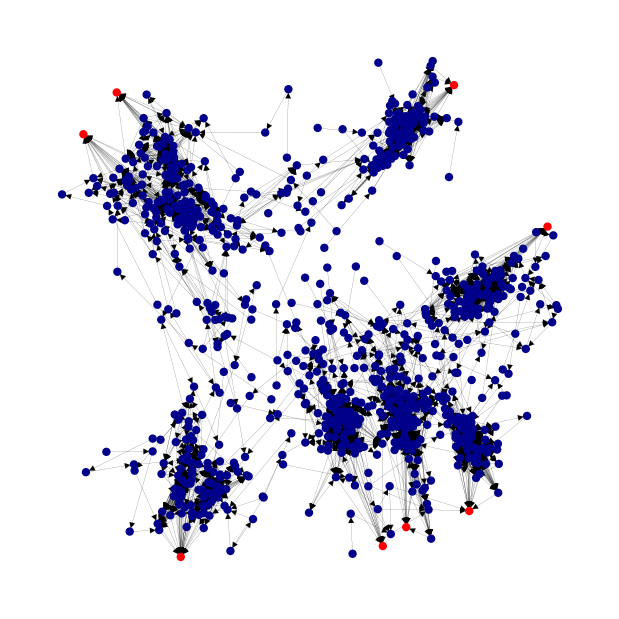

In [118]:
ex_ids = merged_khops_3x[0]
ex_targets, ex_khop = ex_ids
ex_targets, ex_khop = idx_to_id(ex_targets), idx_to_id(ex_khop)
ex_subgraph = G.subgraph(ex_khop + ex_targets)

# draw subgraph, drawing the targets in red
plt.figure(figsize=(6,6))
node_color = ['red' if node in ex_targets else 'darkblue' for node in ex_subgraph.nodes()]

# Using spring_layout with a higher k value to increase space between nodes
pos = nx.spring_layout(ex_subgraph, k=0.1, iterations=45)  # You can adjust k and iterations as needed

nx.draw(ex_subgraph, pos, node_color=node_color, with_labels=False, node_size=25, width=0.1)
plt.show()